In [1]:
import pandas as pd
import numpy as np
from predictables.core.src._UnivariateAnalysis import UnivariateAnalysis
from predictables.util import to_pl_lf
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the breast cancer dataset
bcancer = load_breast_cancer()
cancery = pd.Series(bcancer.target, name="y").map({0: "malignant", 1: "benign"})
cancerdf = pd.DataFrame(
    bcancer.data, columns=[c.replace(" ", "_") for c in bcancer.feature_names]
)

# Standardize the data
scaler = StandardScaler()
cancerdf = pd.DataFrame(scaler.fit_transform(cancerdf), columns=cancerdf.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    cancerdf, cancery, test_size=0.2, random_state=42, stratify=cancery
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# Perform PCA
pca = PCA(n_components=2)
X_train_pca = pd.DataFrame(
    pca.fit_transform(X_train), columns=["pc1", "pc2"], index=X_train.index
)
X_val_pca = pd.DataFrame(
    pca.transform(X_val), columns=["pc1", "pc2"], index=X_val.index
)
X_test_pca = pd.DataFrame(
    pca.transform(X_test), columns=["pc1", "pc2"], index=X_test.index
)

# Combine the data
df_train = pd.concat([X_train, X_train_pca], axis=1)
df_val = pd.concat([X_val, X_val_pca], axis=1)
df_test = pd.concat([X_test, X_test_pca], axis=1)

# Add the target variable
df_train["y"] = y_train.map({"malignant": 0, "benign": 1}).values
df_val["y"] = y_val.map({"malignant": 0, "benign": 1}).values
df_test["y"] = y_test.map({"malignant": 0, "benign": 1}).values

# Randomly sort training data into 5 cross-validation folds
df_train["fold"] = np.random.choice(range(5), size=df_train.shape[0]) + 1

df_train.to_parquet("cancer_train.parquet")
df_val.to_parquet("cancer_val.parquet")
df_test.to_parquet("cancer_test.parquet")

df_train = to_pl_lf(df_train)
df_val = to_pl_lf(df_val)
df_test = to_pl_lf(df_test)

df_train.head().collect()

mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,pc1,pc2,y,fold
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
0.2081,0.912292,0.347273,0.046959,0.57215,1.774977,1.015706,1.02817,-0.272428,0.55604,-0.453216,-0.462029,0.358868,-0.333042,0.346688,1.438701,0.783046,1.140961,0.594217,0.195592,-0.039178,0.342424,0.337735,-0.168554,-0.033692,1.339296,0.895753,0.884571,0.160555,0.169804,2.601883,1.664731,0,5
-1.684571,-0.57005,-1.658278,-1.288347,-0.737294,-0.85113,-0.9155,-1.109197,-0.155598,0.316465,-0.898232,-0.472008,-0.877224,-0.706961,0.642366,-0.50402,-0.530967,-0.953653,0.62933,-0.458783,-1.512777,-0.605327,-1.489328,-1.122222,-0.11698,-0.754239,-0.975761,-1.354653,0.330422,-0.546168,-4.564517,1.565109,1,2
-0.825712,0.132725,-0.825,-0.761051,0.643316,-0.692695,-1.052023,-1.066224,0.468713,-0.356897,-0.38825,1.35921,-0.449022,-0.455811,1.949753,-0.806941,-0.948182,-1.107752,2.65013,-0.69292,-0.888216,0.016737,-0.904036,-0.781363,0.439736,-1.002397,-1.241784,-1.437181,0.632947,-1.037706,-3.127716,1.357112,1,3
-0.169639,-1.943019,-0.167192,-0.27215,2.329937,0.006804,-0.251467,0.429234,2.1591,0.512094,0.017786,-0.368046,-0.105966,-0.169129,2.11976,0.162743,-0.672216,-0.577002,0.626908,0.896114,-0.453343,-2.147457,-0.473631,-0.483572,0.558093,-0.740244,-0.89617,-0.617229,-0.308601,-0.666975,-0.807603,2.071959,1,3
-0.215082,-0.674768,-0.241747,-0.288361,-1.794101,-0.58922,-0.098925,-0.539588,-1.422476,-0.647506,-0.870802,-0.139439,-0.813365,-0.56494,-0.374008,0.403626,0.586093,-0.229711,-1.024602,0.106325,-0.416068,-0.47668,-0.454866,-0.436812,-1.309316,-0.007411,0.28119,-0.378019,-1.379572,-0.424808,-2.212381,-0.936765,1,4


In [2]:
df_train.head().collect()

mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,pc1,pc2,y,fold
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
0.2081,0.912292,0.347273,0.046959,0.57215,1.774977,1.015706,1.02817,-0.272428,0.55604,-0.453216,-0.462029,0.358868,-0.333042,0.346688,1.438701,0.783046,1.140961,0.594217,0.195592,-0.039178,0.342424,0.337735,-0.168554,-0.033692,1.339296,0.895753,0.884571,0.160555,0.169804,2.601883,1.664731,0,5
-1.684571,-0.57005,-1.658278,-1.288347,-0.737294,-0.85113,-0.9155,-1.109197,-0.155598,0.316465,-0.898232,-0.472008,-0.877224,-0.706961,0.642366,-0.50402,-0.530967,-0.953653,0.62933,-0.458783,-1.512777,-0.605327,-1.489328,-1.122222,-0.11698,-0.754239,-0.975761,-1.354653,0.330422,-0.546168,-4.564517,1.565109,1,2
-0.825712,0.132725,-0.825,-0.761051,0.643316,-0.692695,-1.052023,-1.066224,0.468713,-0.356897,-0.38825,1.35921,-0.449022,-0.455811,1.949753,-0.806941,-0.948182,-1.107752,2.65013,-0.69292,-0.888216,0.016737,-0.904036,-0.781363,0.439736,-1.002397,-1.241784,-1.437181,0.632947,-1.037706,-3.127716,1.357112,1,3
-0.169639,-1.943019,-0.167192,-0.27215,2.329937,0.006804,-0.251467,0.429234,2.1591,0.512094,0.017786,-0.368046,-0.105966,-0.169129,2.11976,0.162743,-0.672216,-0.577002,0.626908,0.896114,-0.453343,-2.147457,-0.473631,-0.483572,0.558093,-0.740244,-0.89617,-0.617229,-0.308601,-0.666975,-0.807603,2.071959,1,3
-0.215082,-0.674768,-0.241747,-0.288361,-1.794101,-0.58922,-0.098925,-0.539588,-1.422476,-0.647506,-0.870802,-0.139439,-0.813365,-0.56494,-0.374008,0.403626,0.586093,-0.229711,-1.024602,0.106325,-0.416068,-0.47668,-0.454866,-0.436812,-1.309316,-0.007411,0.28119,-0.378019,-1.379572,-0.424808,-2.212381,-0.936765,1,4


In [3]:
df_train.columns[:-2]

['mean_radius',
 'mean_texture',
 'mean_perimeter',
 'mean_area',
 'mean_smoothness',
 'mean_compactness',
 'mean_concavity',
 'mean_concave_points',
 'mean_symmetry',
 'mean_fractal_dimension',
 'radius_error',
 'texture_error',
 'perimeter_error',
 'area_error',
 'smoothness_error',
 'compactness_error',
 'concavity_error',
 'concave_points_error',
 'symmetry_error',
 'fractal_dimension_error',
 'worst_radius',
 'worst_texture',
 'worst_perimeter',
 'worst_area',
 'worst_smoothness',
 'worst_compactness',
 'worst_concavity',
 'worst_concave_points',
 'worst_symmetry',
 'worst_fractal_dimension',
 'pc1',
 'pc2']

In [4]:
ua = UnivariateAnalysis(
    model_name="Cancer Model",
    df_train=df_train,
    df_val=df_val,
    target_column_name="y",
    feature_column_names=df_train.columns[:-2],
    cv_column_name="fold",
    time_series_validation=False,
)

Performing univariate analysis on 32 features:   0%|          | 0/32 [00:00<?, ?it/s]

Feature mean_radius is right-skewed: skewness = 0.9129022958762187
Feature mean_texture is right-skewed: skewness = 0.6886247411608918
Feature mean_perimeter is right-skewed: skewness = 0.9672810396671019
Feature mean_area is right-skewed: skewness = 1.6121300185962886
Feature mean_smoothness is right-skewed: skewness = 0.6752338638394662
Feature mean_compactness is right-skewed: skewness = 1.2715432747740443
Feature mean_concavity is right-skewed: skewness = 1.3956495221095024
Feature mean_concave_points is right-skewed: skewness = 1.2118145440807047
Feature mean_symmetry is right-skewed: skewness = 0.8051100620489787
Feature mean_fractal_dimension is right-skewed: skewness = 1.2899668174029728
Feature radius_error is right-skewed: skewness = 2.585688157130343
Feature texture_error is right-skewed: skewness = 1.9190239623209937
Feature perimeter_error is right-skewed: skewness = 2.738907688308077
Feature area_error is right-skewed: skewness = 5.187792736911207
Feature smoothness_error

Building 62 univariate analysis reports,and packaging in increments of 15:   0%|          | 0/62 [00:00<?, ?it…

x: 0 | type(x): <class 'int'>
x: 1 | type(x): <class 'int'>
x: 0 | type(x): <class 'int'>
x: 1 | type(x): <class 'int'>
x: 0 | type(x): <class 'int'>
x: 1 | type(x): <class 'int'>
x: 0 | type(x): <class 'int'>
x: 1 | type(x): <class 'int'>
x: 0 | type(x): <class 'int'>
x: 1 | type(x): <class 'int'>
x: 0 | type(x): <class 'int'>
x: 1 | type(x): <class 'int'>
x: 0 | type(x): <class 'numpy.int64'>


ValueError: Invalid value 0 for binary variable.

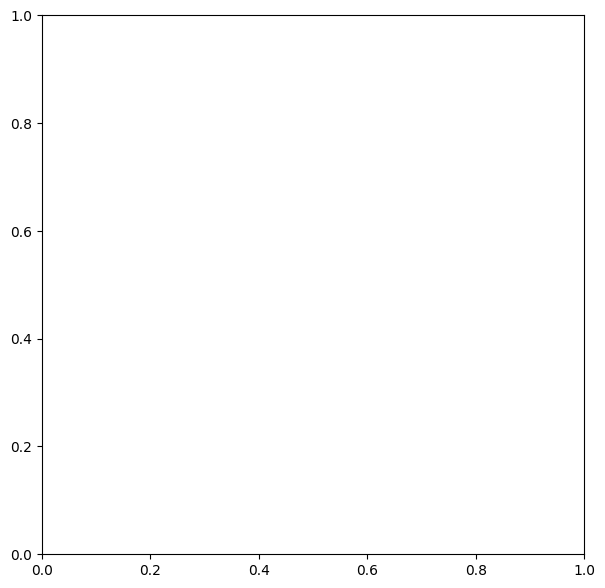

In [5]:
ua.build_report("cancer.pdf", max_per_file=15)